# Chapter7 텍스트 데이터 다루기

## 7.2 예제 애플리케이션 : 영화 리뷰 감성 분석

In [1]:
import pandas as pd
import numpy as np

In [2]:
!tree aclImdb

Local Disk 볼륨에 대한 폴더 경로의 목록입니다.
볼륨 일련 번호는 6AB7-4422입니다.
C:\USERS\THINP\ACLIMDB
├─test
│  ├─neg
│  └─pos
└─train
    ├─neg
    └─pos


In [3]:
from sklearn.datasets import load_files
# 싸이킷런의 load_files 함수를 사용해서 파일을 읽어 오자.

reviews_train = load_files("aclImdb/train/")
# 텍스트와 레이블을 포함하고 있는 Bunch 오브젝트를 반환.

text_train, y_train = reviews_train.data, reviews_train.target
# 해당 변수들에 데이터와 타겟을 할당해주자.

print("text_train의 타입: ", type(text_train))
print("text_train의 길이: ", len(text_train))
print("text_train[6]\n", text_train[6])

text_train의 타입:  <class 'list'>
text_train의 길이:  25000
text_train[6]
 b"This movie has a special way of telling the story, at first i found it rather odd as it jumped through time and I had no idea whats happening.<br /><br />Anyway the story line was although simple, but still very real and touching. You met someone the first time, you fell in love completely, but broke up at last and promoted a deadly agony. Who hasn't go through this? but we will never forget this kind of pain in our life. <br /><br />I would say i am rather touched as two actor has shown great performance in showing the love between the characters. I just wish that the story could be a happy ending."


In [4]:
# 문자열에 포함되어 있는 줄바꿈 태그, "<br />"을 공백으로 전부 바꿔준다.

text_train = [doc.replace(b"<br />",b" ") for doc in text_train]

In [5]:
# 이 데이터셋은 양성 클래스와 음성 클래스를 같은 비율로 수집했기 때문에 레이블의 수가 같다고 한다.

print("클래스별 샘플 수 (훈련 데이터): ", np.bincount(y_train))

클래스별 샘플 수 (훈련 데이터):  [12500 12500]


In [6]:
# 같은 방식으로 테스트 데이터셋을 읽어 준다.

reviews_test = load_files("aclImdb/test/")

text_test, y_test = reviews_test.data, reviews_test.target

print("테스트 데이터의 문서 수:", len(text_test))
print("클래스별 샘플 수 (테스트 데이터):", np.bincount(y_test))

# 마찬가지로 줄바꿈 태그를 없애 준다.
text_test = [doc.replace(b"<br />",b" ") for doc in text_test]

테스트 데이터의 문서 수: 25000
클래스별 샘플 수 (테스트 데이터): [12500 12500]


우리의 goal은 이렇다. 리뷰가 하나 주어졌을 때, 텍스트 내용을 보고 양성인지, 음성인지 가려내는 것이다.

간단한 이진분류지만, 머신러닝 모델이 알고리즘에 적용할 수 있도록 문자열을 수치표현으로 바꿔줘야 한다.

## 7.3 텍스트 데이터를 BOW로 표현하기

BOW(bag of words) 는 텍스트 구조를 무시하고, 각 단어가 얼마나 많이 나타났는지를 알려준다.

- 먼저 단어를 토큰화 시키고
- 어휘를 모아서 번호를 매기고
- 몇 번이나 나타났는지 헤아린다.

이런식으로 진행하는 방법이 BOW이다.

### 7.3.1 샘플 데이터에 BOW 적용하기

BOW 표현은 CountVectorizer에 구현되어 있다.

In [7]:
# 샘플 데이터를 만든다.

bards_words = ["The fool doth think he is wise", "but the wise man knows himself to be a fool"]

In [8]:
# import 하고 fit 해준다.

from sklearn.feature_extraction.text import CountVectorizer
vect = CountVectorizer()
vect.fit(bards_words)

CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=None, vocabulary=None)

In [9]:
# CountVectorizer는 훈련 데이터의 토큰을 vocabulary_ 속성에 저장한다.

print("어휘 사전의 크기:", len(vect.vocabulary_))
print("어휘 사전의 내용:\n", vect.vocabulary_)

어휘 사전의 크기: 13
어휘 사전의 내용:
 {'the': 9, 'fool': 3, 'doth': 2, 'think': 10, 'he': 4, 'is': 6, 'wise': 12, 'but': 1, 'man': 8, 'knows': 7, 'himself': 5, 'to': 11, 'be': 0}


In [10]:
# 훈련 데이터에 대해 BOW 표현을 만드려면 transform 메서드를 호출한다.

bag_of_words = vect.transform(bards_words)
print("BOW:", repr(bag_of_words))

BOW: <2x13 sparse matrix of type '<class 'numpy.int64'>'
	with 16 stored elements in Compressed Sparse Row format>


In [11]:
# toarray메서드를 통해서 행렬을 확인해준다.각 단어의 출연 횟수는 0 아니면 1이다.

print("BOW의 밀집 표현:\n", bag_of_words.toarray())

BOW의 밀집 표현:
 [[0 0 1 1 1 0 1 0 0 1 1 0 1]
 [1 1 0 1 0 1 0 1 1 1 0 1 1]]


### 7.3.2 영화 리뷰에 대한 BOW

In [12]:
# 본격적으로 시작해보자.

vect = CountVectorizer().fit(text_train)
X_train = vect.transform(text_train)
print("X_train:\n", repr(X_train))

# 25000 x 74849 의 크기로 단어를 74849개 가지고 있다.

X_train:
 <25000x74849 sparse matrix of type '<class 'numpy.int64'>'
	with 3431196 stored elements in Compressed Sparse Row format>


In [13]:
# CountVectorizer 객체의 get_feature_name 메서드는 각 특성에 해당하는 단어를 리스트로 반환한다.

feature_names = vect.get_feature_names()
print("특성 개수:", len(feature_names))
print("처음 20개 특성:\n", feature_names[:20])
print("20010에서 20030까지 특성:\n", feature_names[20010:20030])
print("매 2000번째 특성:\n", feature_names[::2000])

특성 개수: 74849
처음 20개 특성:
 ['00', '000', '0000000000001', '00001', '00015', '000s', '001', '003830', '006', '007', '0079', '0080', '0083', '0093638', '00am', '00pm', '00s', '01', '01pm', '02']
20010에서 20030까지 특성:
 ['dratted', 'draub', 'draught', 'draughts', 'draughtswoman', 'draw', 'drawback', 'drawbacks', 'drawer', 'drawers', 'drawing', 'drawings', 'drawl', 'drawled', 'drawling', 'drawn', 'draws', 'draza', 'dre', 'drea']
매 2000번째 특성:
 ['00', 'aesir', 'aquarian', 'barking', 'blustering', 'bête', 'chicanery', 'condensing', 'cunning', 'detox', 'draper', 'enshrined', 'favorit', 'freezer', 'goldman', 'hasan', 'huitieme', 'intelligible', 'kantrowitz', 'lawful', 'maars', 'megalunged', 'mostey', 'norrland', 'padilla', 'pincher', 'promisingly', 'receptionist', 'rivals', 'schnaas', 'shunning', 'sparse', 'subset', 'temptations', 'treatises', 'unproven', 'walkman', 'xylophonist']


In [14]:
# 특성 추출 방법을 개선하기 전에, 분류기를 만들어 성능 수치를 확인해보겠다.
# 이런 희소 행렬의 고차원 데이터셋에서는 LogisticRegression 같은 선형 모델의 성능이 가장 뛰어나다.

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression

scores = cross_val_score(LogisticRegression(), X_train, y_train, cv= 5)
print("교차 검증 평균 점수: {:.2f}". format(np.mean(scores)))

C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


교차 검증 평균 점수: 0.88


In [15]:
# 88% 로 꽤나 훌륭한 점수를 받았다.
# 규제 매개변수 C가 있으므로 그리드 서치를 사용해 조정해보겠다.

from sklearn.model_selection import GridSearchCV
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10]}
grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("최상의 교차 검증 점수: {:2f}". format(grid.best_score_))
print("최적의 매개변수: ", grid.best_params_)

C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


최상의 교차 검증 점수: 0.888160
최적의 매개변수:  {'C': 0.1}


In [16]:
# C = 0.1 에서 교차 검증 점수 89% 를 얻었다. 이 매개변수를 사용해서 테스트 세트의 일반화 성능을 확인하겠다.

X_test = vect.transform(text_test)
print("테스트 점수:{:.2f}".format(grid.score(X_test, y_test)))

테스트 점수:0.88


In [17]:
# 이제 추출 단어를 개선해보자.
# 먼저 min_df 매개변수로 토큰이 나타날 최소 문서 개수를 지정해보자.

vect = CountVectorizer(min_df = 5).fit(text_train)
X_train = vect.transform(text_train)
print("min_df로 제한한 X_train:", repr(X_train))

min_df로 제한한 X_train: <25000x27271 sparse matrix of type '<class 'numpy.int64'>'
	with 3354014 stored elements in Compressed Sparse Row format>


In [18]:
# 위에서는 특성의 개수가 74849개였으나, 27271개로 줄었다.
# 토큰 내용을 다시 살펴보겠다.

feature_names = vect.get_feature_names()
print("처음 50개 특성:\n", feature_names[:50])
print("20010에서 20030까지 특성:\n", feature_names[20010:20030])
print("매 700번째 특성:\n", feature_names[::700])

처음 50개 특성:
 ['00', '000', '007', '00s', '01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '100', '1000', '100th', '101', '102', '103', '104', '105', '107', '108', '10s', '10th', '11', '110', '112', '116', '117', '11th', '12', '120', '12th', '13', '135', '13th', '14', '140', '14th', '15', '150', '15th', '16', '160', '1600', '16mm', '16s', '16th']
20010에서 20030까지 특성:
 ['repentance', 'repercussions', 'repertoire', 'repetition', 'repetitions', 'repetitious', 'repetitive', 'rephrase', 'replace', 'replaced', 'replacement', 'replaces', 'replacing', 'replay', 'replayable', 'replayed', 'replaying', 'replays', 'replete', 'replica']
매 700번째 특성:
 ['00', 'affections', 'appropriately', 'barbra', 'blurbs', 'butchered', 'cheese', 'commitment', 'courts', 'deconstructed', 'disgraceful', 'dvds', 'eschews', 'fell', 'freezer', 'goriest', 'hauser', 'hungary', 'insinuate', 'juggle', 'leering', 'maelstrom', 'messiah', 'music', 'occasional', 'parking', 'pleasantville', 'pronunciation', 'recipient', '

In [19]:
# 그리드 서치로 모델 성능을 다시 확인해보자.

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("최적의 교차 검증 점수: {:2f}". format(grid.best_score_))

C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


최적의 교차 검증 점수: 0.888120


In [20]:
# 89%로 크게 변하지 않았다. 다만 특성 개수가 줄어서 속도가 빨라졌다.

## 7.4 불용어

의미 없는 단어를 제거하는 또 다른 방법은 너무 빈번하여 유용하지 않은 단어를 제외하는 것이다.

- 언어별 불용어 목록을 사용하는 것
- 너무 자주 나타나는 단어를 제외하는 것

이렇게 두개가 있다고 한다.

In [21]:
# 사이킷런에는 feature_extraction.text 모듈에 영어의 불용어를 가지고 있다.

from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
print("불용어 개수:", len(ENGLISH_STOP_WORDS))
print("매 10번째 불용어:\n", list(ENGLISH_STOP_WORDS)[::10])

불용어 개수: 318
매 10번째 불용어:
 ['amount', 'where', 'others', 'during', 'formerly', 'full', 'against', 'his', 'she', 'meanwhile', 'however', 'hence', 'upon', 'most', 'between', 'whoever', 'front', 'anyhow', 'thin', 'because', 'along', 'those', 'elsewhere', 'whereupon', 'himself', 'last', 'although', 'eleven', 'find', 'then', 'myself', 'everyone']


In [22]:
# 불용어가 318개 있다고 한다.
# 이거라도 없애서 성능을 높여 보자.

# stop_words = "english" 라고 지정하면 내장된 불용어를 사용한다.
# 내장된 불용어에 추가할 수도 있고 자신만의 목록을 사용할 수도 있다.

vect = CountVectorizer(min_df = 5, stop_words="english").fit(text_train)
X_train = vect.transform(text_train)
print("불용어가 제거된 X_train:", repr(X_train))

불용어가 제거된 X_train: <25000x26966 sparse matrix of type '<class 'numpy.int64'>'
	with 2149958 stored elements in Compressed Sparse Row format>


In [23]:
# 특성이 305개 줄었다.
# 이걸로 다시 교차검증 하지만 특성 수가 너무 많아서 고작 300개 뺀다고 의미가 있지는 않다.

grid = GridSearchCV(LogisticRegression(), param_grid, cv=5)
grid.fit(X_train, y_train)

print("최상의 교차 검증 점수: {:2f}". format(grid.best_score_))

C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


최상의 교차 검증 점수: 0.882920


## tf-idf로 데이터 스케일 변경하기

tf-idf 는 얼마나 의미 있는 특성인지를 계산해서 스케일을 조정하는 방식이다. 특정 문서에 자주 나타나는 단어에 높은 가중치를 준다.

- tfidf(w,d) = tf(log(N+1/Nw +1) +1)

식은 다음과 같다.
여기서

- N은 훈련 세트에 있는 문서의 개수고,
- Nw 는 단어 w가 나타난 훈련 세트 문서의 개수이며,
- tf(단어 빈도수)는 단어 w가 대상 문서 d(변환 또는 인코딩 하려는 문서)dp skxksks ghlttndlek.
- 두 파이썬 클래스 모두 tf-idf 계산을 한 후 L2 정규화를 적용한다.

이렇게 스케일이 바뀐 벡터의 문서의 길이(단어의 수)에 영향을 받지 않는다.

In [24]:
# tf-idf 는 훈련 데이터의 통계적 속성을 사용하기 때문에 파이프라인을 이용하여 그리드 서치를 적용해보겠다.

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
pipe = make_pipeline(TfidfVectorizer(min_df = 5), LogisticRegression())
param_grid = {'logisticregression__C': [0.001, 0.01, 0.1, 1, 10]}

grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(text_train, y_train)
print("최상의 교차 검증 점수:{:.2f}".format(grid.best_score_))

C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


최상의 교차 검증 점수:0.89


In [26]:
# tf-idf 가 별 성능을 내지 못했다. 

vectorizer = grid.best_estimator_.named_steps["tfidfvectorizer"]
# 훈련 데이터셋을 변환합니다.

X_train = vectorizer.transform(text_train)
# 특성별로 가장 큰 값을 찾습니다.

max_value = X_train.max(axis = 0).toarray().ravel()
sorted_by_tfidf = max_value.argsort()

# 특성 이름을 구합니다.
feature_names = np.array(vectorizer.get_feature_names())

print("가장 낮은 tfidf를 가진 특성:\n", feature_names[sorted_by_tfidf[:20]])
print("가장 높은 tfidf를 가진 특성:\n", feature_names[sorted_by_tfidf[-20:]])

가장 낮은 tfidf를 가진 특성:
 ['suplexes' 'gauche' 'hypocrites' 'oncoming' 'songwriting' 'galadriel'
 'emerald' 'mclaughlin' 'sylvain' 'oversee' 'cataclysmic' 'pressuring'
 'uphold' 'thieving' 'inconsiderate' 'ware' 'denim' 'reverting' 'booed'
 'spacious']
가장 높은 tfidf를 가진 특성:
 ['gadget' 'sucks' 'zatoichi' 'demons' 'lennon' 'bye' 'dev' 'weller'
 'sasquatch' 'botched' 'xica' 'darkman' 'woo' 'casper' 'doodlebops'
 'smallville' 'wei' 'scanners' 'steve' 'pokemon']


In [27]:
sorted_by_idf = np.argsort(vectorizer.idf_)
print("가장 낮은 idf를 가진 특성:\n", feature_names[sorted_by_idf[:100]])

가장 낮은 idf를 가진 특성:
 ['the' 'and' 'of' 'to' 'this' 'is' 'it' 'in' 'that' 'but' 'for' 'with'
 'was' 'as' 'on' 'movie' 'not' 'have' 'one' 'be' 'film' 'are' 'you' 'all'
 'at' 'an' 'by' 'so' 'from' 'like' 'who' 'they' 'there' 'if' 'his' 'out'
 'just' 'about' 'he' 'or' 'has' 'what' 'some' 'good' 'can' 'more' 'when'
 'time' 'up' 'very' 'even' 'only' 'no' 'would' 'my' 'see' 'really' 'story'
 'which' 'well' 'had' 'me' 'than' 'much' 'their' 'get' 'were' 'other'
 'been' 'do' 'most' 'don' 'her' 'also' 'into' 'first' 'made' 'how' 'great'
 'because' 'will' 'people' 'make' 'way' 'could' 'we' 'bad' 'after' 'any'
 'too' 'then' 'them' 'she' 'watch' 'think' 'acting' 'movies' 'seen' 'its'
 'him']


## 7.6 모델 계수 조사

마지막으로 LogisticRegression 모델이 실제로 이 데이터에서 무엇을 학습했는지 살펴보겠다.

In [31]:
pip install mglearn

  Stored in directory: C:\Users\thinp\AppData\Local\pip\Cache\wheels\74\cf\8d\04f4932d15854a36726c6210763c7127e62de28f5c8ddfcf3b
Successfully built mglearn
Note: you may need to restart the kernel to use updated packages.


In [32]:
import mglearn

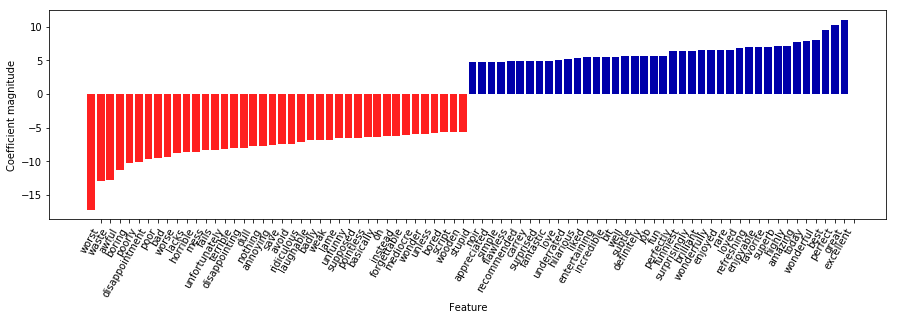

In [35]:
# 가장 큰 계소 40개와 가장 작은 계수 40개를 보여준다. 막대의 크기는 계수의 크기이다.

mglearn.tools.visualize_coefficients(
    grid.best_estimator_.named_steps["logisticregression"].coef_[0],
    feature_names, n_top_features=40)

## 7.7 여러 단어로 만든 BOW(n-그램)

BOW 표현 방식의 큰 단점은 단어의 순서를 완전히 무시한다는 것이다.

 - it's bad, not good at all
 - it's good, not bad at all
 
 위 두 문장을 BOW는 완전히 동일하게 변환한다.
 이러한 단점을 보완하기 위해 토큰 하나의 횟수만 고려하지 않고 옆에 있는 두세 개의 토큰을 함께 고려하는 방식이 있다.
 토큰 두 개를 바이그램, 세 개를 트라이그램, 그 이후를 n-그램 이라고 한다.

In [36]:
print("bards_words:\n", bards_words)

bards_words:
 ['The fool doth think he is wise', 'but the wise man knows himself to be a fool']


In [37]:
# 토큰의 연속성은 ngram_range 매개변수를 통해 조정한다.

cv = CountVectorizer(ngram_range = (1,1)).fit(bards_words)
print("어휘 사전 크기:",  len(cv.vocabulary_))
print("어휘 사전:\n", cv.get_feature_names())

어휘 사전 크기: 13
어휘 사전:
 ['be', 'but', 'doth', 'fool', 'he', 'himself', 'is', 'knows', 'man', 'the', 'think', 'to', 'wise']


In [38]:
# 바이그램으로 만들어보자.

cv = CountVectorizer(ngram_range = (2,2)).fit(bards_words)
print("어휘 사전 크기:",  len(cv.vocabulary_))
print("어휘 사전:\n", cv.get_feature_names())

어휘 사전 크기: 14
어휘 사전:
 ['be fool', 'but the', 'doth think', 'fool doth', 'he is', 'himself to', 'is wise', 'knows himself', 'man knows', 'the fool', 'the wise', 'think he', 'to be', 'wise man']


In [40]:
print("변환된 데이터(밀집배열):\n", cv.transform(bards_words).toarray())

변환된 데이터(밀집배열):
 [[0 0 1 1 1 0 1 0 0 1 0 1 0 0]
 [1 1 0 0 0 1 0 1 1 0 1 0 1 1]]


In [41]:
# bards_words에 유니그램, 바이그램, 트라이그램을 적용하면 다음과 같다.

cv = CountVectorizer(ngram_range = (1,3)).fit(bards_words)
print("어휘 사전 크기:",  len(cv.vocabulary_))
print("어휘 사전:\n", cv.get_feature_names())

어휘 사전 크기: 39
어휘 사전:
 ['be', 'be fool', 'but', 'but the', 'but the wise', 'doth', 'doth think', 'doth think he', 'fool', 'fool doth', 'fool doth think', 'he', 'he is', 'he is wise', 'himself', 'himself to', 'himself to be', 'is', 'is wise', 'knows', 'knows himself', 'knows himself to', 'man', 'man knows', 'man knows himself', 'the', 'the fool', 'the fool doth', 'the wise', 'the wise man', 'think', 'think he', 'think he is', 'to', 'to be', 'to be fool', 'wise', 'wise man', 'wise man knows']


In [44]:
# 그렇다면 IMDB 영화 리뷰 데이터의 TfidfVectorizer를 적용하고 그리드 서치로 최적의 n-그램 범위를 찾아보자.

pipe = make_pipeline(TfidfVectorizer(min_df = 5), LogisticRegression())
# 매개변수 조합이 많고 트라이그램이 포함되어 있기 때문에 시간이 오래 걸린다.

param_grid = {'logisticregression__C' : [0.001, 0.01, 0.1, 1, 10],
              'tfidfvectorizer__ngram_range': [(1,1),(1,2),(1,3)]}

grid = GridSearchCV(pipe, param_grid, cv = 5)
grid.fit(text_train, y_train)

print("최상의 교차 검증 점수:{:.2f}".format(grid.best_score_))
print("최적의 매개변수:\n", grid.best_params_)

C:\Users\thinp\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


KeyboardInterrupt: 